# 5. Modeling

## 5.1 Imports

In [27]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import os

## 5.2 Load previously processed data

In [28]:
# Intermediate data was saved as '../data/baf_cat_dummy_na_median_num_scaled.csv.gz' previously.
baf_data = pd.read_csv('../data/baf_cat_dummy_na_median_num_scaled.csv.gz', compression='gzip')


In [29]:
# Validate data types and non-null values.
baf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993563 entries, 0 to 993562
Data columns (total 53 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        993563 non-null  int64  
 1   email_is_free                     993563 non-null  int64  
 2   phone_home_valid                  993563 non-null  int64  
 3   phone_mobile_valid                993563 non-null  int64  
 4   has_other_cards                   993563 non-null  int64  
 5   foreign_request                   993563 non-null  int64  
 6   keep_alive_session                993563 non-null  int64  
 7   payment_type_AA                   993563 non-null  int64  
 8   payment_type_AB                   993563 non-null  int64  
 9   payment_type_AC                   993563 non-null  int64  
 10  payment_type_AD                   993563 non-null  int64  
 11  payment_type_AE                   993563 non-null  i

In [30]:
# Print target column `fraud_bool` value count
print(baf_data['fraud_bool'].value_counts())
# Print the pencentage of fraud instances of all records
fraud_bool_1 = len(baf_data[baf_data['fraud_bool']==1]) / len(baf_data)
fraud_bool_0 = len(baf_data[baf_data['fraud_bool']==0]) / len(baf_data)
print(f'fraud_bool=1 of all ratio: {fraud_bool_1: .3f}')
print(f'fraud_bool=0 of all ratio: {fraud_bool_0: .3f}')

fraud_bool
0    982568
1     10995
Name: count, dtype: int64
fraud_bool=1 of all ratio:  0.011
fraud_bool=0 of all ratio:  0.989


The fraud category is quite inbalanced. We need to consider it in later modeling.

## 5.3 Split data into training and testing subsets

All the features will be used for modeling at the first step.

In [31]:
# split dataset into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(baf_data.drop(columns='fraud_bool'), baf_data.fraud_bool, test_size=0.3, random_state=47)

In [32]:
X_train.shape, X_test.shape

((695494, 52), (298069, 52))

In [33]:
y_train.shape, y_test.shape

((695494,), (298069,))

## 5.4 Applying the Machine Learning models

Fraud or not is a classification problem. The following supervised learning classification models will be used:

- Logistic Regression
- Random Forest
- K-Nearest Neighbor (KNN)
- Gradient Boost

For evaluation metrics, F1 score, Recall, Precision, ROC AUC, PR AUC will be calculated and compared.

In [34]:
# Import modules
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt


In [35]:
# Initialize a DataFrame to save model name and metrics
table = pd.DataFrame(columns=['model_name', 'Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])

# Function to calculate metrics and return a dictionary
def calculate_metrics(model_name, y_test, y_pred, y_score):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)
    
    # Compute the precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Return a dictionary with the results
    return {
        'model_name': model_name,
        'Accuracy_score': accuracy,
        'Precision_score': precision,
        'Recall_score': recall,
        'F1_score': f1,
        'roc_auc_score': roc_auc,
        'pr_auc': pr_auc
    }


### 5.4.1 Logistic Regression

As the fraud class is quite inbalanced, class_weight='balanced' will be used in Logistic Regression modeling.

In [36]:
from sklearn.linear_model import LogisticRegression

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight='balanced', random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('Logistic_Regression_C1_balanced', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

C:\Windows\Temp\ipykernel_5912\3450119011.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)


[[237180  57620]
 [   716   2553]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    294800
           1       0.04      0.78      0.08      3269

    accuracy                           0.80    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.80      0.88    298069

                        model_name  Accuracy_score  Precision_score  \
0  Logistic_Regression_C1_balanced        0.804287         0.042428   

   Recall_score  F1_score  roc_auc_score    pr_auc  
0      0.780973  0.080483        0.87257  0.125287  


With the built in 'balanced' class_weight, Recall score is 0.78, which is fairly good. But Precision is only 0.04, quite low. F1 score is 0.08, pr_auc 0.125. Accuracy score 0.804 and roc_auc score 0.873 high, but doesn't seem to be the best metrics for inbalanced data classification in the current model. Precision and Recall may be better.

In [37]:
# Define plot_roc_pr_curves function to draw ROC and Precision_Recall curves
def plot_roc_pr_curves(model_name, y_test, y_score):
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # Create a figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot ROC curve on the first subplot
    ax1.plot([0, 1], [0, 1], linestyle='--')
    ax1.plot(fpr, tpr, marker='.', markersize=1.5, label=model_name)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve - {model_name}')
    ax1.legend()

    # Plot Precision-Recall curve on the second subplot
    ax2.plot([0, 1], [1, 0], linestyle='--')
    ax2.plot(recall, precision, marker='.', markersize=1.5, label=model_name)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curve - {model_name}')
    ax2.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


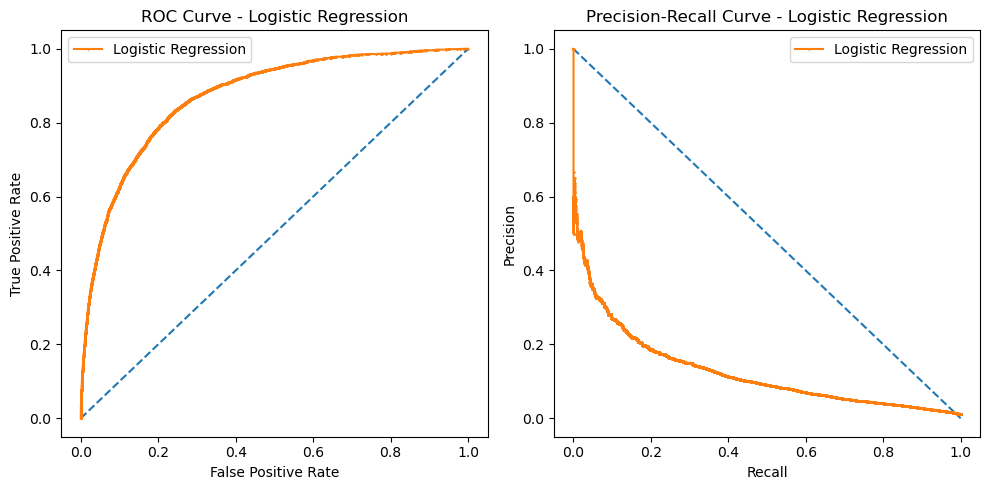

In [38]:
# Draw ROC and Precision-Recall Curves for Logistic Regression
plot_roc_pr_curves("Logistic Regression", y_test, y_score)

From the above two charts, we can see that ROC curve doesn't show the impact of class inbalance. Precision recall curve may be better to use.

### 5.4.2 Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1, class_weight='balanced')
rfc.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('Random Forest', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[247194  47606]
 [   842   2427]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    294800
           1       0.05      0.74      0.09      3269

    accuracy                           0.84    298069
   macro avg       0.52      0.79      0.50    298069
weighted avg       0.99      0.84      0.90    298069

                        model_name  Accuracy_score  Precision_score  \
0  Logistic_Regression_C1_balanced        0.804287         0.042428   
1                    Random Forest        0.837460         0.048508   

   Recall_score  F1_score  roc_auc_score    pr_auc  
0      0.780973  0.080483       0.872570  0.125287  
1      0.742429  0.091066       0.874928  0.128604  


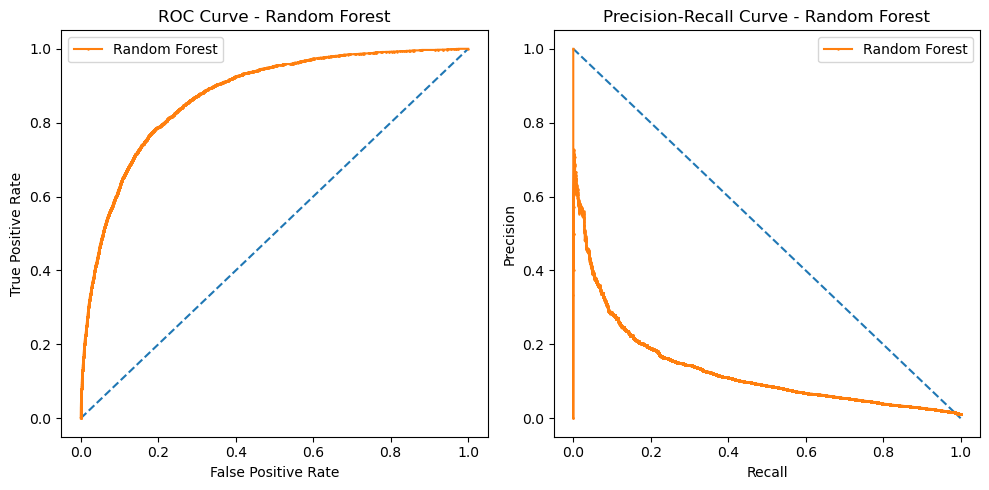

In [40]:
# Draw ROC and Precision-Recall Curves for Random Forest
plot_roc_pr_curves("Random Forest", y_test, y_score)

### 5.4.3 Gradient Boost

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, max_depth=10, random_state=47)
gbc.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = gbc.predict(X_test)
y_score = gbc.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('Gradient Boosting', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[293450   1350]
 [  3072    197]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.13      0.06      0.08      3269

    accuracy                           0.99    298069
   macro avg       0.56      0.53      0.54    298069
weighted avg       0.98      0.99      0.98    298069

                        model_name  Accuracy_score  Precision_score  \
0  Logistic_Regression_C1_balanced        0.804287         0.042428   
1                    Random Forest        0.837460         0.048508   
2                Gradient Boosting        0.985165         0.127343   

   Recall_score  F1_score  roc_auc_score    pr_auc  
0      0.780973  0.080483       0.872570  0.125287  
1      0.742429  0.091066       0.874928  0.128604  
2      0.060263  0.081811       0.876348  0.090367  


In [ ]:
# Draw ROC and Precision-Recall Curves for Gradient Boosting
plot_roc_pr_curves("Gradient Boosting", y_test, y_score)

### 5.4.4 K-Nearest neighbor (KNN)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, n_jobs=-1)
knn.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('KNN', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[294800      0]
 [  3269      0]]


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.00      0.00      0.00      3269

    accuracy                           0.99    298069
   macro avg       0.49      0.50      0.50    298069
weighted avg       0.98      0.99      0.98    298069

                        model_name  Accuracy_score  Precision_score  \
0  Logistic_Regression_C1_balanced        0.804287         0.042428   
1                              KNN        0.989033         0.000000   

   Recall_score  F1_score  roc_auc_score    pr_auc  
0      0.780973  0.080483       0.872570  0.125287  
1      0.000000  0.000000       0.770316  0.092424  


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It seems KNN modeling doesn't work well on the current data set. Is it possible for Recall and Precision bother to be 0? Need to discuss with Mentor and try different upsampling or different parameters with KNN and try again.

In [23]:

cv_scores_train= cross_val_score(gbc, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
# cv_scores_test= cross_val_score(gbc, X_test, y_test, scoring='f1', cv=5, n_jobs=-1)
print(f'cross validation train scores: {cv_scores_train}')
# print(f'cross validation test scores: {cv_scores_test}')
cv_scores_rf_train= cv_scores_train.mean()
# cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train_std= cv_scores_train.std()
# cv_scores_std_rf= cv_scores_test.std()
print (f'Mean cross validation train score: {cv_scores_rf_train}')
print (f'Standard deviation of cv train scores: {cv_scores_rf_train_std}')
# print (f'Mean cross validation test score: {cv_scores_rf_test}')

cross validation train scores: [0.0793177  0.07705479 0.07017544 0.07839795 0.08490963]
Mean cross validation train score: 0.07797110221487549
Standard deviation of cv train scores: 0.0047275918429300545


## 5.5 Modeling with resampled training data

The current results of precision and recall are not great at the same time, which may be related to the inbalance data of the fraud type. Next, we are going to use resampled training data trying to improve the modeling performance.

### 5.5.1 The Synthetic Minority Oversampling Technique (SMOTE)

In [22]:
from collections import Counter
from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 687768), (1, 687768)]


#### 5.5.1.1 RandomForest Modeling

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)
rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('SMOTE_Random Forest', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[265789  29011]
 [  1287   1982]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    294800
           1       0.06      0.61      0.12      3269

    accuracy                           0.90    298069
   macro avg       0.53      0.75      0.53    298069
weighted avg       0.98      0.90      0.94    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.898352         0.06395     0.606302  0.115697   

  roc_auc_score    pr_auc  
0      0.866954  0.112036  


#### 5.5.1.2 XGboost Modeling

In [13]:
from xgboost import XGBClassifier

# Apply XGBClassifier to training data
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('SMOTE_xgb', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294287    513]
 [  2996    273]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.35      0.08      0.13      3269

    accuracy                           0.99    298069
   macro avg       0.67      0.54      0.56    298069
weighted avg       0.98      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb       0.988228        0.347328     0.083512  0.134649   

  roc_auc_score    pr_auc  
0      0.878641  0.141921  


#### 5.5.1.3 KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, n_jobs=-1)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('SMOTE_KNN', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[222956  71844]
 [   945   2324]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    294800
           1       0.03      0.71      0.06      3269

    accuracy                           0.76    298069
   macro avg       0.51      0.73      0.46    298069
weighted avg       0.99      0.76      0.85    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.755798        0.031334     0.710921  0.060023   

  roc_auc_score    pr_auc  
0      0.801767  0.084731  


#### 5.5.1.4 Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('SMOTE_LogisticRegression', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[281414  13386]
 [  1897   1372]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    294800
           1       0.09      0.42      0.15      3269

    accuracy                           0.95    298069
   macro avg       0.54      0.69      0.56    298069
weighted avg       0.98      0.95      0.96    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0          0.1       0.948727        0.092967       0.4197  0.152216   

  roc_auc_score    pr_auc  
0      0.845516  0.103601  


#### 5.5.2 Under-sampling with RandomUnderSampler

In [19]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))

[(0, 7726), (1, 7726)]


#### 5.5.2.1 RandomForest Modeling

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)
rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('RandomUnderSampler_Random Forest', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[239652  55148]
 [   747   2522]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    294800
           1       0.04      0.77      0.08      3269

    accuracy                           0.81    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.81      0.89    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.812476        0.043732      0.77149  0.082771   

  roc_auc_score    pr_auc  
0      0.873721  0.132063  


#### 5.5.2.2 XGboost Modeling

In [15]:
from xgboost import XGBClassifier

# Apple XGBClassifier to training data
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('RandomUnderSampler_xgb', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[238011  56789]
 [   676   2593]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    294800
           1       0.04      0.79      0.08      3269

    accuracy                           0.81    298069
   macro avg       0.52      0.80      0.49    298069
weighted avg       0.99      0.81      0.88    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb       0.807209        0.043666     0.793209  0.082776   

  roc_auc_score    pr_auc  
0      0.881439  0.135744  


#### 5.5.2.3 KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('RandomUnderSampler_KNN', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[217780  77020]
 [   710   2559]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    294800
           1       0.03      0.78      0.06      3269

    accuracy                           0.74    298069
   macro avg       0.51      0.76      0.46    298069
weighted avg       0.99      0.74      0.84    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.739221        0.032157     0.782808  0.061776   

  roc_auc_score    pr_auc  
0        0.8365  0.083528  


#### 5.5.2.4 Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('RandomUnderSampler_LogisticRegression', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[237651  57149]
 [   726   2543]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    294800
           1       0.04      0.78      0.08      3269

    accuracy                           0.81    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.81      0.88    298069

   C_parameter Accuracy_score Precision_score Recall_score F1_score  \
0          0.1       0.805834        0.042602     0.777914  0.08078   

  roc_auc_score    pr_auc  
0      0.872246  0.125622  


#### 5.5.3 Under-sampling by removing Tomek’s links

In [13]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(n_jobs=-1)
X_train_resampled, y_train_resampled = tl.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))


[(0, 685578), (1, 7726)]


#### 5.5.3.1 RandomForest Modeling

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Apply RandomForestClassifier to training data
# Add class_weight='balanced'
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, class_weight='balanced', random_state=47, n_jobs=-1)
rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingRmTomekLinks_Random Forest', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[246382  48418]
 [   842   2427]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    294800
           1       0.05      0.74      0.09      3269

    accuracy                           0.83    298069
   macro avg       0.52      0.79      0.50    298069
weighted avg       0.99      0.83      0.90    298069

  criterion Accuracy_score Precision_score Recall_score F1_score  \
0   entropy       0.834736        0.047733     0.742429   0.0897   

  roc_auc_score    pr_auc  
0      0.873076  0.127794  


#### 5.5.3.2 XGboost Modeling

In [30]:
from xgboost import XGBClassifier

# Apply XGBClassifier to training data
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingRmTomekLinks_xgb', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294604    196]
 [  3111    158]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.45      0.05      0.09      3269

    accuracy                           0.99    298069
   macro avg       0.72      0.52      0.54    298069
weighted avg       0.98      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb       0.988905        0.446328     0.048333  0.087221   

  roc_auc_score    pr_auc  
0      0.885752  0.154913  


#### 5.5.3.3 KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingRmTomekLinks_KNN', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294800      0]
 [  3268      1]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       1.00      0.00      0.00      3269

    accuracy                           0.99    298069
   macro avg       0.99      0.50      0.50    298069
weighted avg       0.99      0.99      0.98    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.989036             1.0     0.000306  0.000612   

  roc_auc_score    pr_auc  
0      0.771262  0.093185  


#### 5.5.3.4 Logistic Regression

In [32]:
# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingRmTomekLinks_LogisticRegression', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294772     28]
 [  3229     40]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.59      0.01      0.02      3269

    accuracy                           0.99    298069
   macro avg       0.79      0.51      0.51    298069
weighted avg       0.98      0.99      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0          0.1       0.989073        0.588235     0.012236  0.023974   

  roc_auc_score    pr_auc  
0      0.871424  0.130207  


#### 5.5.4 Under-sampling by EditedNearestNeighbours

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors=3, n_jobs=-1)
X_train_resampled, y_train_resampled = enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 667924), (1, 7726)]


#### 5.5.4.1 RandomForest Modeling

In [16]:
# from sklearn.ensemble import RandomForestClassifier

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, class_weight='balanced', random_state=47, n_jobs=-1)
rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingEditedNearestNeighbours_Random Forest', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[246942  47858]
 [   840   2429]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    294800
           1       0.05      0.74      0.09      3269

    accuracy                           0.84    298069
   macro avg       0.52      0.79      0.50    298069
weighted avg       0.99      0.84      0.90    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.836622        0.048303     0.743041  0.090709   

  roc_auc_score    pr_auc  
0      0.873774  0.126791  


#### 5.5.4.2 XGboost Modeling

In [35]:
from xgboost import XGBClassifier

# Apply xgbClassifier to training data
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingEditedNearestNeighbours_xgb', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294387    413]
 [  2994    275]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.40      0.08      0.14      3269

    accuracy                           0.99    298069
   macro avg       0.69      0.54      0.57    298069
weighted avg       0.98      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb        0.98857        0.399709     0.084124  0.138994   

  roc_auc_score    pr_auc  
0      0.889849  0.160301  


#### 5.5.4.3 KNN

In [36]:
# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingEditedNearestNeighbours_KNN', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294793      7]
 [  3256     13]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.65      0.00      0.01      3269

    accuracy                           0.99    298069
   macro avg       0.82      0.50      0.50    298069
weighted avg       0.99      0.99      0.98    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.989053            0.65     0.003977  0.007905   

  roc_auc_score    pr_auc  
0      0.774667  0.096543  


#### 5.5.4.4 Logistic Regression

In [37]:
# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('UnderSamplingEditedNearestNeighbours_LogisticRegression', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294705     95]
 [  3184     85]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.47      0.03      0.05      3269

    accuracy                           0.99    298069
   macro avg       0.73      0.51      0.52    298069
weighted avg       0.98      0.99      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score F1_score  \
0          0.1       0.988999        0.472222     0.026002  0.04929   

  roc_auc_score    pr_auc  
0      0.871013  0.130367  


#### 5.5.5 Stacking modeling

It seems the precision and recall was not very great at the same time still. To improve it, stacking modeling will be tried out.

In [12]:
from sklearn.ensemble import StackingClassifier
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

pipe_xgb = Pipeline_imb([
    ('rus', RandomUnderSampler(random_state=42)), 
    ('model_1', XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr', n_jobs=-1))
])

pipe_knn = Pipeline_imb([
    ('enn', EditedNearestNeighbours(n_neighbors=3, n_jobs=-1)), 
    ('model_2', KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, n_jobs=-1))
])

level0 = list()
level0.append(('xgboost', pipe_xgb))
level0.append(('knn', pipe_knn))

level1 = LogisticRegression(random_state=74, n_jobs=-1)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

# Calculate metrics and store them in a dictionary
metrics = calculate_metrics('stacking modeling 1', y_test, y_pred, y_score)

# Append the metrics as a new row to the DataFrame using pd.concat
table = pd.concat([table, pd.DataFrame([metrics])], ignore_index=True)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[294770     30]
 [  3233     36]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.55      0.01      0.02      3269

    accuracy                           0.99    298069
   macro avg       0.77      0.51      0.51    298069
weighted avg       0.98      0.99      0.98    298069



In [13]:
print(table)

      model Accuracy_score Precision_score Recall_score  F1_score  \
0  stacking       0.989053        0.545455     0.011013  0.021589   

  roc_auc_score    pr_auc  
0      0.881819  0.129291  


In [14]:
from sklearn.ensemble import StackingClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression

pipe_xgb = Pipeline_imb([
    ('rus', RandomUnderSampler(random_state=42)), 
    ('model_1', XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr', n_jobs=-1))
])

pipe_lgb = Pipeline_imb([
    ('tl', TomekLinks(n_jobs=-1)), 
    ('model_2', LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000, n_jobs=-1))
])

level0 = list()
level0.append(('xgboost', pipe_xgb))
level0.append(('lbg', pipe_lgb))

level1 = LogisticRegression(random_state=74, n_jobs=-1)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

table = pd.DataFrame(columns = ['model','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['model'] = ['stacking']

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(table)

[[294740     60]
 [  3207     62]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.51      0.02      0.04      3269

    accuracy                           0.99    298069
   macro avg       0.75      0.51      0.52    298069
weighted avg       0.98      0.99      0.98    298069

      model Accuracy_score Precision_score Recall_score  F1_score  \
0  stacking       0.989039        0.508197     0.018966  0.036567   

  roc_auc_score    pr_auc  
0      0.884291  0.144066  


In [15]:
from sklearn.ensemble import StackingClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pipe_rfc = Pipeline_imb([
    ('rus', RandomUnderSampler(random_state=42)), 
    ('model_1', RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1))
])

pipe_xgb = Pipeline_imb([
    ('tl', TomekLinks(n_jobs=-1)), 
    ('model_2', XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr', n_jobs=-1))
])

level0 = list()
level0.append(('rfc', pipe_rfc))
level0.append(('xgb', pipe_xgb))

level1 = LogisticRegression(random_state=74, n_jobs=-1)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

table = pd.DataFrame(columns = ['model','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['model'] = ['stacking']

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(table)

[[294699    101]
 [  3144    125]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.55      0.04      0.07      3269

    accuracy                           0.99    298069
   macro avg       0.77      0.52      0.53    298069
weighted avg       0.98      0.99      0.98    298069

      model Accuracy_score Precision_score Recall_score  F1_score  \
0  stacking       0.989113        0.553097     0.038238  0.071531   

  roc_auc_score    pr_auc  
0      0.877583  0.153836  


#### 5.5.6 Neural network modeling

#### 5.5.6.1 Oversample the minority class with SMOTE

In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))


[(0, 687768), (1, 687768)]


#### 5.5.6.2 Build the Neural Network Model

In [16]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_recall_curve, auc
import tensorflow as tf

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with precision, recall, and AUC metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[Precision(), Recall(), AUC(name='auc')]
)


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Create a Custom Callback for AUC-PR

class AUC_PR(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUC_PR, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.asarray(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        precision, recall, _ = precision_recall_curve(val_targ, val_predict)
        auc_pr = auc(recall, precision)
        print(f' - val_auc_pr: {auc_pr:.4f}')
        logs['val_auc_pr'] = auc_pr

In [18]:
# Train the Model with the Custom Callback

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Define early stopping and custom AUC-PR callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
auc_pr_callback = AUC_PR(validation_data=(X_val_split, y_val_split))

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=32,    # limit of memory, also the running speed
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, auc_pr_callback],
    verbose=1
)

Epoch 1/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9920
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - auc: 0.9673 - loss: 0.2146 - precision: 0.9184 - recall: 0.9096 - val_auc: 0.9910 - val_loss: 0.1186 - val_precision: 0.9629 - val_recall: 0.9421 - val_auc_pr: 0.9920
Epoch 2/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
 - val_auc_pr: 0.9926
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - auc: 0.9879 - loss: 0.1364 - precision: 0.9570 - recall: 0.9392 - val_auc: 0.9915 - val_loss: 0.1139 - val_precision: 0.9612 - val_recall: 0.9490 - val_auc_pr: 0.9926
Epoch 3/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
 - val_auc_pr: 0.9927
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - auc: 0.9886 - loss: 0.1320 - precision: 0.9577 - recall: 0.9420 - val_auc: 0.9917 - val_loss: 0.1127 - val_precision: 0.9625 - val_recall: 0.9487 - val_auc_pr: 0.9927
Epoch 4/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
 - val_auc_pr: 0.9929
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/s

#### 5.5.6.3 Evaluate the Model

In [19]:
# Evaluate on the test data
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

9315/9315 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - auc: 0.8440 - loss: 0.1173 - precision: 0.1058 - recall: 0.3602
loss: 0.11628413200378418
compile_metrics: 0.1044442430138588
9315/9315 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    294800
           1       0.10      0.36      0.16      3269

    accuracy                           0.96    298069
   macro avg       0.55      0.66      0.57    298069
weighted avg       0.98      0.96      0.97    298069

[[284785  10015]
 [  2101   1168]]


In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_score))

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
print(auc(recall, precision))

0.9593516937353431
0.10444424573012609
0.3572958091159376
0.1616385275394409
0.8725704481845618
0.12528700350742578


Drop out test.

In [12]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_recall_curve, auc
import tensorflow as tf

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model with precision, recall, and AUC metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[Precision(), Recall(), AUC(name='auc')]
)

# Create a Custom Callback for AUC-PR

class AUC_PR(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUC_PR, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.asarray(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        precision, recall, _ = precision_recall_curve(val_targ, val_predict)
        auc_pr = auc(recall, precision)
        print(f' - val_auc_pr: {auc_pr:.4f}')
        logs['val_auc_pr'] = auc_pr

# Train the Model with the Custom Callback

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Define early stopping and custom AUC-PR callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
auc_pr_callback = AUC_PR(validation_data=(X_val_split, y_val_split))

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=32,    # limit of memory, also the running speed
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, auc_pr_callback],
    verbose=1
)

# Evaluate on the test data
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9928
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - auc: 0.9774 - loss: 0.1793 - precision: 0.9339 - recall: 0.9207 - val_auc: 0.9918 - val_loss: 0.1123 - val_precision: 0.9570 - val_recall: 0.9549 - val_auc_pr: 0.9928
Epoch 2/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9932
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - auc: 0.9903 - loss: 0.1220 - precision: 0.9574 - recall: 0.9487 - val_auc: 0.9924 - val_loss: 0.1089 - val_precision: 0.9552 - val_recall: 0.9609 - val_auc_pr: 0.9932
Epoch 3/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9935
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - auc: 0.9909 - loss: 0.1181 - precision: 0.9586 - recall: 0.9511 - val_auc: 0.9927 - val_loss: 0.1058 - val_precision: 0.9576 - val_recall: 0.9607 - val_auc_pr: 0.9935
Epoch 4/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
 - val_auc_pr: 0.9938
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 125s 4ms/s

In [13]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    294800
           1       0.10      0.37      0.16      3269

    accuracy                           0.96    298069
   macro avg       0.55      0.67      0.57    298069
weighted avg       0.98      0.96      0.97    298069

[[284224  10576]
 [  2056   1213]]


Normalization

In [12]:
from collections import Counter
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

#---------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_recall_curve, auc
import tensorflow as tf

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model with precision, recall, and AUC metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[Precision(), Recall(), AUC(name='auc')]
)

# Create a Custom Callback for AUC-PR

class AUC_PR(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUC_PR, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.asarray(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        precision, recall, _ = precision_recall_curve(val_targ, val_predict)
        auc_pr = auc(recall, precision)
        print(f' - val_auc_pr: {auc_pr:.4f}')
        logs['val_auc_pr'] = auc_pr

# Train the Model with the Custom Callback

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Define early stopping and custom AUC-PR callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
auc_pr_callback = AUC_PR(validation_data=(X_val_split, y_val_split))

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=32,    # limit of memory, also the running speed
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, auc_pr_callback],
    verbose=1
)

# Evaluate on the test data
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

#--------------------------------------
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_score))

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
print(auc(recall, precision))


[(0, 687768), (1, 687768)]


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9926
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - auc: 0.9740 - loss: 0.1939 - precision: 0.9260 - recall: 0.9196 - val_auc: 0.9916 - val_loss: 0.1146 - val_precision: 0.9611 - val_recall: 0.9473 - val_auc_pr: 0.9926
Epoch 2/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9929
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - auc: 0.9873 - loss: 0.1396 - precision: 0.9506 - recall: 0.9443 - val_auc: 0.9921 - val_loss: 0.1121 - val_precision: 0.9545 - val_recall: 0.9574 - val_auc_pr: 0.9929
Epoch 3/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
 - val_auc_pr: 0.9931
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - auc: 0.9890 - loss: 0.1307 - precision: 0.9539 - recall: 0.9467 - val_auc: 0.9923 - val_loss: 0.1102 - val_precision: 0.9649 - val_recall: 0.9458 - val_auc_pr: 0.9931
Epoch 4/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9933
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms